In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import random
import pickle

In [47]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [48]:
# NUMBER_NODES = 10
NUMBER_NODES = 9
# NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

In [49]:
def load_data():
    # not being used, but works as another approach to load the data
    def get_split_tensor_dataset(df, numberDigits):
        # df.iloc[row_start (0 default) : row_end (last default) , col_start (0 default) : col_end (last default)]
        X_df = df.iloc[ : , 0: numberDigits]
        Y_df = df.iloc[ : , numberDigits + 1 : ] # skip bandwidth value, and get the remaining labels
        X = X_df.to_numpy()
        Y = Y_df.to_numpy()
        return torch.from_numpy(X), torch.from_numpy(Y)

    # numberDigits = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2
    # if numberDigits == 45: # o de 10 nao ta otimizado AJEITAR
    #   numberDigits = 100
    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2) + 1

    def get_tuple_tensor_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        # Y = row[numberDigits + 1 : ].astype('float32') # o de 10 nao ta otimizado AJEITAR
        Y = row[featuresNumber : ].astype('float32')
        return torch.from_numpy(X), torch.from_numpy(Y)
        

    df = pd.read_csv(DATASET_PATH)
    # df = df.sample(frac=1).reset_index(drop=True) # shuffle
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_tensor_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_tensor_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_tensor_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

    # X_train, Y_train = get_split_tensor_dataset(train_dataset_df, numberDigits)
    # X_val, Y_val = get_split_tensor_dataset(val_dataset_df, numberDigits)
    # X_test, Y_test = get_split_tensor_dataset(test_dataset_df, numberDigits)
    # return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [50]:
training_data, val_data, test_data = load_data()

# Save test_Data to use it in compareResults
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [51]:
for x, y in train_dataloader:
    print("Shape of X [Batches, Digits in each Batch]: ", x.shape)
    print("Grad = ", x.requires_grad)
    print("Shape of y [Batches, Optimal labels in each Batch]: ", y.shape)
    break

Shape of X [Batches, Digits in each Batch]:  torch.Size([16, 37])
Grad =  False
Shape of y [Batches, Optimal labels in each Batch]:  torch.Size([16, 9])


In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2) + 1, 200)
        self.fc2 = nn.Linear(200, NUMBER_NODES)

    def forward(self, x):
        # print("FELIPEEEEEEEEEEEEE")
        # print(type(x))
        # print(x[0])
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# MSE including opt_band only in training
class CustomLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        #return ((output-target)**2).mean() + (output % 1).sum(dim=1).mean()
        # print("FELIPE")
        # print(output[0].round())
        # print(target[0])
        return ((output - target)**2).mean()
        # np.linalg.norm(a-b) # euclidean distance, this is the same as "np.sqrt(np.sum(np.power((b - a), 2)))"
        #return ((output-target)**2).sum(dim=1).mean()

In [53]:
# train v2 https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train(dataloader, model, loss_fn, optimizer, goal, epoch):
    model.train() # turn on possible layers/parts specific for training, like Dropouts for example
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # print statistics
        if not batch and epoch % 20:
            print(f'Epoch {epoch + 1} Loss: {loss.item()}')

        # goal
        # if loss.item() <= goal:
        #     print('The goal of learning is reached')
        #     print(f'{epoch + 1} Loss: {loss.item()}')
        #     break
    return (train_loss / len(dataloader))

def validate(dataloader, model, loss_fn):
    model.eval() # turn off possible layers/parts specific for training, like Dropouts for example
    eval_loss = 0
    # with torch.no_grad(): # turn off gradients computation
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        eval_loss += loss.item()
    return (eval_loss / len(dataloader))
    

def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad(): # turn off gradients computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            correct += torch.all(y.eq(pred.round())).item()
    test_loss /= num_batches
    correct /= size
    if epoch % 10 == 0:
      print(f"Test loss:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [54]:
epochs = 64

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNetwork().to(device)
print(model)

loss_fn = CustomLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

list_train_loss = []
list_val_loss = []

goal = 0.5e-3

for epoch in range(epochs):
    # for each epoch, we got a loss training and a loss validating.
    train_epoch_loss = train(train_dataloader, model, loss_fn, optimizer, goal, epoch)
    list_train_loss.append(train_epoch_loss)
    val_epoch_loss = validate(val_dataloader, model, loss_fn)
    list_val_loss.append(val_epoch_loss)
    # test(test_dataloader, model, loss_fn, epoch)
    # if list_train_loss[-1] <= goal:
    #         break

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Using cuda device
NeuralNetwork(
  (fc1): Linear(in_features=37, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=9, bias=True)
)
Epoch 2 Loss: 22.22916603088379
Epoch 3 Loss: 22.42361068725586
Epoch 4 Loss: 22.26388931274414
Epoch 5 Loss: 22.05555534362793
Epoch 6 Loss: 22.02777862548828
Epoch 7 Loss: 22.15277862548828
Epoch 8 Loss: 22.27083396911621
Epoch 9 Loss: 22.48611068725586
Epoch 10 Loss: 21.9375
Epoch 11 Loss: 21.96527862548828
Epoch 12 Loss: 22.13194465637207
Epoch 13 Loss: 22.29166603088379
Epoch 14 Loss: 22.16666603088379
Epoch 15 Loss: 22.125
Epoch 16 Loss: 22.15277862548828
Epoch 17 Loss: 22.20833396911621
Epoch 18 Loss: 22.25694465637207
Epoch 19 Loss: 22.27083396911621
Epoch 20 Loss: 22.61111068725586
Epoch 22 Loss: 21.86111068725586
Epoch 23 Loss: 22.39583396911621
Epoch 24 Loss: 22.16666603088379
Epoch 25 Loss: 21.88194465637207
Epoch 26 Loss: 22.29166603088379
Epoch 27 Loss: 22.40277862548828
Epoch 28 Loss: 22.32638931274414
Epoch 29 Loss: 

64
64
Loss val array:
Loss val first:
22.22478954089858
Loss val last:
22.224726949872668
[22.222581440242458, 22.222589869017995, 22.222577221549475, 22.22257637147805, 22.222599140504432, 22.22256458546894, 22.222594923339106, 22.222566256725198, 22.22258986929575, 22.222577223632644, 22.222578917525993, 22.222582277814876, 22.22257047819574, 22.22257975926475, 22.22258734032978, 22.222573851400263, 22.22257048083442, 22.22257132285093, 22.222578066482424, 22.222578065093643, 22.22256374095263, 22.222573850705874, 22.222575530850317, 22.222567107629892, 22.222586485536507, 22.222579753709635, 22.222575545988004, 22.222571319795616, 22.222593232639948, 22.222588187345895, 22.222581439964703, 22.222583117609343, 22.22255614988839, 22.222589869156874, 22.222561211986662, 22.222590707701436, 22.222586498313273, 22.222560370525663, 22.22258564518653, 22.222581438437047, 22.22257721418895, 22.222567105685602, 22.22257470022179, 22.22257974759901, 22.222571334933303, 22.222554463911077, 22.

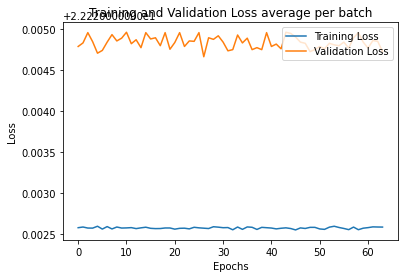

In [55]:
print(len(list_train_loss))
print(len(list_val_loss))
print("Loss val array:")
# print(list_val_loss)
print("Loss val first:")
print(list_val_loss[0])
print("Loss val last:")
print(list_val_loss[-1])

print(list_train_loss)

plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss average per batch')
plt.show()

In [56]:
print(test_data[0])
print(type(test_data[0]))

for x, y in test_dataloader:
  x, y = x.to(device), y.to(device)
  pred = model(x).round()
  print("=============")
  print(pred)
  print(y)
  np_true = y.cpu().detach().numpy()
  np_pred = pred.cpu().detach().numpy()

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.]), tensor([1., 8., 4., 5., 6., 7., 0., 2., 3.]))
<class 'tuple'>
tensor([[-0., 0., -0., 1., -0., -0., -0., 1., -0.],
        [-0., 0., -0., 1., -0., -0., -0., 0., -0.],
        [-0., -0., 0., 1., -0., -0., -0., 1., -0.],
        [0., 0., -0., 0., -0., -0., -0., 0., 0.],
        [-0., -0., 0., 1., -0., -0., -0., 0., -0.],
        [-0., 0., 0., 0., -0., -0., -0., 0., -0.],
        [-0., -0., -0., 0., -0., -0., -0., 0., 0.],
        [-0., -0., -0., 1., -0., -0., -0., 0., 0.],
        [-0., -0., -0., 0., -0., -0., -0., 0., -0.],
        [-0., -0., 0., 0., -0., -0., -0., 0., 0.],
        [-0., 0., 0., 1., -0., -0., -0., 1., 0.],
        [0., 0., -0., 1., -0., -0., -0., 0., -0.],
        [0., -0., 0., 0., -0., -0., -0., 0., 0.],
        [-0., -0., -0., 0., -0., -0., -0., 0., 0.],
        [0., -0., -0., 0., -0., -0., -0., 0

In [57]:
def load_data_v1():
    # numberDigits = 100 # o de 10 nao ta otimizado AJEITAR
    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2) + 1

    def get_split_tensor_dataset(df, numberDigits):
        # df.iloc[row_start (0 default) : row_end (last default) , col_start (0 default) : col_end (last default)]
        # o de 10 nao ta otimizado AJEITAR
        X = df.iloc[ : , 0: numberDigits].values.astype('float32')
        Y = df.iloc[ : , numberDigits : ].values.astype('float32')
        return torch.from_numpy(X), torch.from_numpy(Y)

    df = pd.read_csv(DATASET_PATH)
    # df = df.sample(frac=1).reset_index(drop=True) # shuffle
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    X_train, Y_train = get_split_tensor_dataset(train_dataset_df, featuresNumber)
    X_val, Y_val = get_split_tensor_dataset(val_dataset_df, featuresNumber)
    X_test, Y_test = get_split_tensor_dataset(test_dataset_df, featuresNumber)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [58]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data_v1()
print(X_train.shape)
print(X_val.shape)
print(Y_val.shape)

torch.Size([219734, 37])
torch.Size([38454, 37])
torch.Size([38454, 9])


In [59]:
# train v1

model_v1 = NeuralNetwork()

loss_fn = CustomLoss()
optimizer = optim.SGD(model_v1.parameters(), lr=0.001)

epochs = 64
goal = 0.5e-3
batch_size = 16
train_size = len(X_train)
val_size = len(X_val)
steps = int(np.ceil(train_size / batch_size))
steps_val = int(np.ceil(val_size / batch_size))

list_train_loss_v1 = list()
list_val_loss_v1 = list()

print('\nTraining')
for epoch in range(epochs):
    start = 0
    end = batch_size
    loss_train = 0.0
    model.train()
    for batch in range(steps):
        x = X_train[start : end]
        y = Y_train[start : end]

        pred = model_v1(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()

        start += batch_size
        end += batch_size

        # print statistics
        if not batch:
            print(f'Epoch {epoch + 1} Loss: {loss.item()}')
        # goal
        # if loss.item() <= goal:
        #     print('The goal of learning is reached')
        #     print(f'{epoch + 1} Loss: {loss.item()}')
        #     break
    start = 0
    end = batch_size
    loss_val = 0.0
    model.eval()
    for batch in range(steps_val):
        x = X_val[start : end]
        y = Y_val[start : end]
        pred = model_v1(x)
        loss = loss_fn(pred, y)
        loss_val += loss.item()
        start += batch_size
        end += batch_size

    list_train_loss_v1.append(loss_train / steps)
    list_val_loss_v1.append(loss_val / steps_val)
print('Finished Training')


Training
Epoch 1 Loss: 23.59722137451172
Epoch 2 Loss: 23.59722137451172
Epoch 3 Loss: 23.59722137451172
Epoch 4 Loss: 23.59722137451172
Epoch 5 Loss: 23.59722137451172
Epoch 6 Loss: 23.59722137451172
Epoch 7 Loss: 23.59722137451172
Epoch 8 Loss: 23.59722137451172
Epoch 9 Loss: 23.59722137451172
Epoch 10 Loss: 23.59722137451172
Epoch 11 Loss: 23.59722137451172
Epoch 12 Loss: 23.59722137451172


KeyboardInterrupt: 

[5.750450801741735, 5.438349005556947, 5.348948219379032, 5.3010043673802105, 5.271265330057018, 5.249444478304952, 5.23069425099313, 5.213820509450898, 5.198591982431246, 5.184857950801496, 5.172169638249453, 5.159923539839406, 5.148324539172904, 5.137135527514814, 5.126221050771022, 5.115574701967346, 5.105135576805208, 5.094994852024516, 5.085131092416645, 5.075609169118144, 5.06643894375959, 5.057660294651933, 5.049227731464314, 5.041178711293583, 5.033460578874016, 5.025993578972489, 5.018862238856613, 5.0119456724254645, 5.005309543374221, 4.998949734269227, 4.992761933857373, 4.9867936462159586, 4.981054847810195, 4.975526992976448, 4.970167773388281, 4.9649769646017, 4.959979189992454, 4.955129113575074, 4.95039987954681, 4.945766064491233, 4.9412844053293155, 4.936960039795686, 4.9327615792702355, 4.928727650618091, 4.924798106685448, 4.921011712382033, 4.917340921491137, 4.913737974382825, 4.910222807027062, 4.906787260522727, 4.9034459276353495, 4.900205437960333, 4.89698608

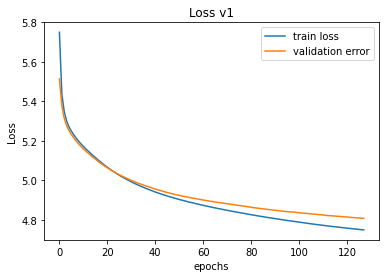

In [ ]:
# consolidate
print(list_train_loss_v1)
fig, ax = plt.subplots()
ax.plot(list_train_loss_v1, label='train loss')
ax.plot(list_val_loss_v1, label='validation error')
ax.set(xlabel='epochs', ylabel='Loss', title='Loss v1')

plt.legend()
#plt.savefig('loss.png')
plt.show()

In [ ]:
print(X_test[0])
print(type(X_test[0]))

for i in range(len(X_test)):
  pred = model_v1(X_test[i])
  print("====")
  print(pred.round())
  print(Y_test[i])

tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.])
<class 'torch.Tensor'>
tensor([3., 4., 4., 5., 0., 4., 5., 5., 4.], grad_fn=<RoundBackward>)
tensor([1., 8., 0., 7., 3., 4., 6., 2., 5.])
[0.  0.  0.  0.  0.4 0.  0.  0.  0. ]
0.1111111111111111
0.044444444444444446
0.044444444444444446

tensor([4., 4., 3., 4., 3., 5., 4., 4., 4.], grad_fn=<RoundBackward>)
tensor([1., 7., 8., 0., 2., 6., 5., 3., 4.])
[0.         0.         0.         0.         0.28571429 0.
 0.         0.         0.        ]
0.1111111111111111
0.031746031746031744
0.031746031746031744

tensor([3., 4., 4., 3., 2., 7., 4., 4., 4.], grad_fn=<RoundBackward>)
tensor([1., 7., 0., 2., 8., 3., 4., 6., 5.])
[0.         0.         0.         0.         0.33333333 0.
 0.         0.         0.        ]
0.1111111111111111
0.03703703703703704
0.03703703703703704

tensor([3., 4., 4., 2., 2., 8., 5., 4., 3.], grad

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
it = iter(train_dataloader)
it2 = iter(train_dataloader)
it3 = iter(train_dataloader)
i1 = next(it)[1]
i2 = next(it2)[1]
i3 = next(it3)[1]
print(i1)
print(i2)
print(i3)
print(np.array_equal(i1, i2))
print(np.array_equal(i1, i3))
print(np.array_equal(i2, i3))

tensor([[5., 6., 1., 8., 0., 7., 4., 3., 2.],
        [1., 5., 6., 8., 4., 7., 2., 0., 3.],
        [1., 4., 5., 8., 7., 0., 2., 6., 3.],
        [3., 1., 7., 8., 6., 4., 2., 5., 0.],
        [5., 3., 0., 8., 6., 4., 7., 1., 2.],
        [6., 5., 8., 1., 2., 7., 3., 0., 4.],
        [1., 4., 6., 0., 7., 8., 2., 5., 3.],
        [3., 0., 6., 4., 8., 7., 1., 5., 2.],
        [1., 3., 6., 4., 8., 7., 2., 0., 5.],
        [1., 4., 6., 7., 8., 3., 2., 0., 5.],
        [1., 4., 6., 2., 8., 7., 3., 5., 0.],
        [3., 0., 7., 5., 6., 8., 4., 2., 1.],
        [1., 6., 5., 8., 7., 0., 2., 3., 4.],
        [2., 1., 3., 5., 8., 7., 0., 6., 4.],
        [0., 3., 6., 5., 7., 8., 1., 2., 4.],
        [1., 7., 2., 8., 3., 6., 0., 4., 5.]])
tensor([[1., 5., 7., 4., 8., 2., 0., 6., 3.],
        [1., 4., 5., 7., 8., 0., 2., 3., 6.],
        [3., 8., 6., 0., 1., 5., 2., 4., 7.],
        [6., 2., 1., 5., 7., 8., 3., 0., 4.],
        [2., 5., 6., 1., 8., 0., 4., 7., 3.],
        [2., 5., 7., 6., 0., 1., 